### Utility Functions

In [1]:
import tensorflow as tf
from IPython.display import clear_output

2021-12-13 01:09:11.087492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 01:09:11.087561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import zlib
import numpy as np
import pandas as pd
import sqlite3 as sql
from contextlib import contextmanager
from tensorflow.keras import layers


_CMP = '_cmp'


@contextmanager
def open_db_connection(*, file, close=True,
                       lock=None, check_same_thread=False):
    """
    Safety wrapper for the database call.
    """

    if lock is not None:
        lock.acquire()

    con = sql.connect(database=file, check_same_thread=check_same_thread)

    try:
        yield con

    finally:
        if close:
            con.close()
        if lock is not None:
            lock.release()


def get_table_name(file):
    with open_db_connection(file=file, close=True) as con:
        res = pd.read_sql_query(sql="SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%'",
                                con=con)
        return res['name'].values


def rename_table(file, tables):
    old_names = get_table_name(file=file)

    with open_db_connection(file=file, close=True) as con:
        cur = con.cursor()
        for old in old_names:
            if old in tables:
                new = tables['old']
                cur.execute(f"ALTER TABLE `{old}` RENAME TO `{new}`")


def get_values_sql(*, file, table='db', columns=None, rows=-1,
                   values_only=False, squeeze_col=True, squeeze_row=True):
    """
    'i_samples' == i_samples_global
    """

    lock = None  # Lock is not necessary fo reading
    if columns is None:
        columns = '*'
    if isinstance(columns, str):
        columns = [columns]
    columns_str = ', '.join(map(str, columns))

    if isinstance(rows, int):
        rows = [rows]
    rows = np.array(rows)

    if rows[0] == -1:  # All samples
        with open_db_connection(file=file, close=True, lock=lock) as con:
            df = pd.read_sql_query(con=con, sql=f"SELECT {columns_str} FROM {table}")  # path_db

    else:
        rows_str = rows + 1  # Attention! Unlike in Python, SQL indices start at 1
        rows_str = ', '.join(map(str, rows_str))
        with open_db_connection(file=file, close=True, lock=lock) as con:
            df = pd.read_sql_query(sql=f"SELECT {columns_str} FROM {table} WHERE ROWID in ({rows_str})",
                                   index_col=rows, con=con)

    value_list = []
    if np.any(columns == ['*']):
        columns = df.columns.values

    if values_only:
        for col in columns:
            value = __decompress_values(value=df.loc[:, col].values, col=col)
            value_list.append(value)

        if len(df) == 1 and squeeze_row:
            for i in range(len(columns)):
                value_list[i] = value_list[i][0]

        if len(value_list) == 1 and squeeze_col:
            value_list = value_list[0]

        return value_list

    # Return pandas.DataFrame
    else:
        for col in columns:
            value = __decompress_values(value=df.loc[:, col].values, col=col)
            df.loc[:, col] = numeric2object_array(value)

        return df


def set_values_sql(*, file, table='db',
                   values, columns, rows=-1, lock=None):
    """
    Note: multidimensional numpy arrays have to be saved as flat to SQL otherwise the order is messed up
    values = ([...], [...], [...], ...)
    """

    # Handle rows argument
    if isinstance(rows, int):
        if rows == -1:
            rows = np.arange(len(values[0])).tolist()
        else:
            rows = [rows]

    rows_sql = (np.array(rows) + 1).tolist()  # Attention! Unlike in Python, SQL indices start at 1

    # Handle columns argument
    if isinstance(columns, str):
        columns = [columns]

    columns_str = '=?, '.join(map(str, columns))
    columns_str += '=?'

    values_rows_sql = change_tuple_order(values + (rows_sql,))
    values_rows_sql = list(values_rows_sql)
    query = f"UPDATE {table} SET {columns_str} WHERE ROWID=?"

    with open_db_connection(file=file, close=True, lock=lock) as con:
        cur = con.cursor()
        if len(values_rows_sql) == 1:
            cur.execute(query, values_rows_sql[0])
        else:
            cur.executemany(query, values_rows_sql)

        con.commit()


def df2sql(df, file, table='db', if_exists='fail', lock=None):
    """
    From DataFrame.to_sql():
        if_exists : {'fail', 'replace', 'append'}, default 'fail'
                   - fail: If table exists, do nothing.
                   - replace: If table exists, drop it, recreate it, and insert Measurements.
                   - append: If table exists, insert Measurements. Create if does not exist.
    """
    with open_db_connection(file=file, close=True, lock=lock) as con:
        df.to_sql(name=table, con=con, if_exists=if_exists, index=False)


# Helper
# Image Compression <-> Decompression
def __decompress_values(value, col):
    # SQL saves everything in binary form -> convert back to numeric, expect the columns which are marked as CMP
    if isinstance(value[0], bytes) and col[-4:] != _CMP:
        if col in ['i_world', 'i_sample', 'n_obstacles']:
            value = np.array([np.frombuffer(v, dtype=int) for v in value], dtype=int)
        elif col in ['rectangle_pos', 'rectangle_position', 'rectangle_size']:
            value = np.array([np.frombuffer(v, dtype=int) for v in value], dtype=object)
        else:
            value = np.array([np.frombuffer(v, dtype=float) for v in value])
        value = np.squeeze(value)

    return value


def change_tuple_order(tpl):
    return tuple(map(lambda *tt: tuple(tt), *tpl))


def numeric2object_array(arr):
    n = arr.shape[0]
    arr_obj = np.zeros(n, dtype=object)
    for i in range(n):
        arr_obj[i] = arr[i]

    return arr_obj


def object2numeric_array(arr):
    s = np.shape(arr)
    arr = np.array([v for v in np.ravel(arr)])
    arr = np.reshape(arr, s + np.shape(arr)[1:])
    return arr


def initialize_array(shape, mode='zeros', dtype=None, order='c'):

    if mode == 'zeros':
        return np.zeros(shape, dtype=dtype, order=order)
    elif mode == 'ones':
        return np.ones(shape, dtype=dtype, order=order)
    elif mode == 'empty':
        return np.empty(shape, dtype=dtype, order=order)
    elif mode == 'random':
        return np.random.random(shape).astype(dtype=dtype, order=order)
    else:
        raise ValueError(f"Unknown initialization method {mode}")


def __dim_voxels(n_voxels, n_dim=None):
    if np.size(n_voxels) == 1:
        try:
            n_voxels = tuple(n_voxels)
        except TypeError:
            n_voxels = (n_voxels,)
        n_voxels *= n_dim
    else:
        n_voxels = tuple(n_voxels)

    return n_voxels


def image_array_shape(n_voxels, n_samples=None, n_dim=None, n_channels=None):
    """
    Helper to set the shape for an image array.
    n_samples=100,  n_voxels=64,          n_dim=2,    n_channels=None  ->  (100, 64, 64)
    n_samples=100,  n_voxels=64,          n_dim=3,    n_channels=2     ->  (100, 64, 64, 64, 2)
    n_samples=None, n_voxel=(10, 11, 12), n_dim=None, n_channels=None  ->  (10, 11, 12)
    """

    shape = __dim_voxels(n_voxels=n_voxels, n_dim=n_dim)

    if n_samples is not None:
        shape = (n_samples,) + shape
    if n_channels is not None:
        shape = shape + (n_channels,)

    return shape


def initialize_image_array(n_voxels, n_dim=None, n_samples=None, n_channels=None,
                           dtype=bool, initialization='zeros'):
    shape = image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_samples=n_samples, n_channels=n_channels)
    return initialize_array(shape=shape, mode=initialization, dtype=dtype)


# Image Compression <-> Decompression
def img2compressed(img, n_dim=-1, level=9):
    """
    Compress the given image with the zlib routine to a binary string.
    Level of compression can be adjusted. A timing with respect to different compression levels for decompression showed
    no difference, so the highest level is default, this corresponds to the largest compression.
    For compression it is slightly slower but this happens just once and not during keras training, so the smaller
    needed memory was favoured.
    Alternative:
    <-> use numpy sparse for the world images, especially in 3d  -> zlib is more effective and more general
    """

    if n_dim == -1:
        return zlib.compress(img.tobytes(), level=level)
    else:
        shape = img.shape[:-n_dim]
        img_cmp = np.empty(shape, dtype=object)
        for idx in np.ndindex(*shape):
            img_cmp[idx] = zlib.compress(img[idx, ...].tobytes(), level=level)
        return img_cmp


def compressed2img(img_cmp, n_voxels, n_dim=None, n_channels=None, dtype=bool):
    """
    Decompress the binary string back to an image of given shape
    """

    shape = np.shape(img_cmp)

    if shape:
        n_samples = np.size(img_cmp)
        img_arr = initialize_image_array(n_voxels=n_voxels, n_dim=n_dim, n_samples=n_samples, n_channels=n_channels,
                                         dtype=dtype)
        for i in range(n_samples):
            img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(
                image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_channels=n_channels))
        return img_arr

    else:
        return np.fromstring(zlib.decompress(img_cmp), dtype=dtype).reshape(
            image_array_shape(n_voxels=n_voxels, n_dim=n_dim, n_channels=n_channels))
    






class create_dataset(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

### Main

/tmp/ipykernel_3254/1979238740.py:277: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(


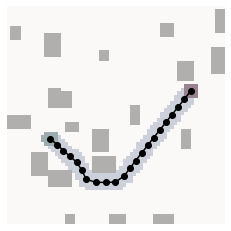

In [3]:
import numpy as np

file = '../SingleSphere02.db'
# TODO change to you own directory


n_voxels = 64
voxel_size = 10 / 64     # in m
extent = [0, 10, 0, 10]  # in m
n_waypoints = 22  # start + 20 inner points + end
n_dim = 2
n_paths_per_world = 1000
n_worlds = 5000


worlds = get_values_sql(file=file, table='worlds')
obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)

# always 1000 paths belong to one world
# 0...999     -> world 0
# 1000...1999 -> world 1
# 2000...2999 -> world 2
paths = get_values_sql(file=file, table='paths', rows=[0, 1, 2, 1000, 2000])
path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
start_images = compressed2img(img_cmp=paths.start_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
end_images = compressed2img(img_cmp=paths.end_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)

q_paths = object2numeric_array(paths.q_path.values)
q_paths = q_paths.reshape(-1, n_waypoints, n_dim)

# Plot an example
i = 0
i_world = paths.i_world[i]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.imshow(obstacle_images[i_world].T, origin='lower', extent=extent, cmap='binary',)
ax.imshow(start_images[i].T, origin='lower', extent=extent, cmap='Greens', alpha=0.4)
ax.imshow(end_images[i].T, origin='lower', extent=extent, cmap='Reds', alpha=0.4)
ax.imshow(path_images[i].T, origin='lower', extent=extent, cmap='Blues', alpha=0.2)
ax.axis('off')
ax.plot(*q_paths[i].T, color='k', marker='o')
plt.show()

# Creating Image datasets

In [4]:
def load_images_for_single_world(world_index, file='../SingleSphere02.db', paths_per_world=1000):
    
    """ Returns an array of tuples where each tuple contains:
        1. Obstacle image of the desired world with different start & end points
        2. Above image plus the path from start to end point
    """
    
    # Initial Parameters
    n_voxels = 64
    voxel_size = 10 / 64     # in m
    extent = [0, 10, 0, 10]  # in m
    n_waypoints = 22  # start + 20 inner points + end
    n_dim = 2
    n_paths_per_world = 1000
    n_worlds = 5000

    worlds = get_values_sql(file=file, table='worlds')
    obstacle_image = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)[world_index]
    
    # always 1000 paths belong to one world
    # 0...999     -> world 0
    # 1000...1999 -> world 1
    # 2000...2999 -> world 2
    path_range_start  = world_index * paths_per_world
    path_range_end = world_index * paths_per_world + paths_per_world
    n_world_all_paths = [x for x in range(path_range_start, path_range_end)]
    
    paths = get_values_sql(file=file, table='paths', rows=n_world_all_paths)
    
    # Decompressing objects to images
    path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    start_images = compressed2img(img_cmp=paths.start_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    end_images = compressed2img(img_cmp=paths.end_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)

    input_images = []
    output_images = []
    for i in n_world_all_paths:
        input_images.append(np.concatenate((obstacle_images[i_world].T[:,:,np.newaxis], start_images[i].T[:,:,np.newaxis],end_images[i].T[:,:,np.newaxis]), axis=-1))
        #input_images.append(obstacle_images[i_world].T + start_images[i].T + end_images[i].T)
        output_images.append(np.expand_dims(path_images[i].T, axis=2))
    return input_images, output_images

In [5]:
input_images, output_images = load_images_for_single_world(0)

/tmp/ipykernel_3254/1979238740.py:277: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_arr[i, ...] = np.fromstring(zlib.decompress(img_cmp[i]), dtype=dtype).reshape(


In [6]:
# Display Images
def plot_image(image_array):
    ''' Displays numpy arrays'''
    return tf.keras.utils.array_to_img(tf.image.resize(image_array.astype('uint8'), (256, 256)))

(64, 64, 3)


2021-12-13 01:09:17.718954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-13 01:09:17.719038: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-13 01:09:17.719106: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2cc49966f54a): /proc/driver/nvidia/version does not exist
2021-12-13 01:09:17.719737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


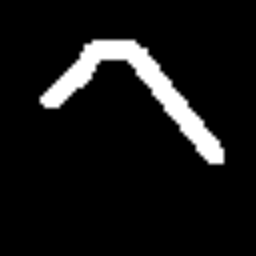

In [7]:
print(input_images[0].shape)
plot_image(output_images[0])

# Creating tensorflow Datasets

In [8]:
def list_to_np_arrays(list_of_images):
    ''' Returns a singular numpy array from a list of images. \
        It is used to arrange images to be compatible while making tensorflow datasets
    '''
    
    length = list_of_images[0].shape[0]
    width  = list_of_images[0].shape[1]
    depth  = list_of_images[0].shape[2]
    
    imgs   = np.empty((0, length, width, depth))
    
    for img in list_of_images:
        imgs = np.append(imgs, np.array(img).reshape((1, length, width, depth)), axis=0)
        
    return imgs



In [9]:
# Reshaping
input_images = np.reshape(input_images, (-1, 64, 64, 3))
print("Input Images Shape after Reshaping: ",input_images.shape)
output_images = np.reshape(output_images, (-1, 64, 64, 1))
print("Output Images Shape after Reshaping: ",output_images.shape)

Input Images Shape after Reshaping:  (1000, 64, 64, 3)
Output Images Shape after Reshaping:  (1000, 64, 64, 1)


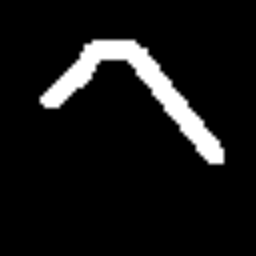

In [10]:
plot_image(output_images[0])

In [11]:
X = list_to_np_arrays(input_images)
y = list_to_np_arrays(output_images)

from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
# Converting numpy arrays to tf Dataset
train_images_ds = tf.data.Dataset.from_tensor_slices((
            tf.cast(data_train, tf.float32),
            tf.cast(labels_train, tf.float32)
        ))

test_images_ds = tf.data.Dataset.from_tensor_slices((
            tf.cast(data_test, tf.float32),
            tf.cast(labels_test, tf.float32)
        ))

In [13]:

#plot_image(a[0])

 (64, 64, 3)


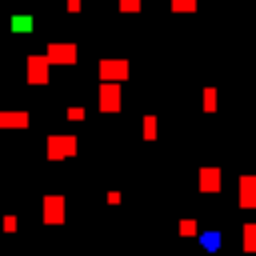

In [14]:
a,b = train_images_ds.take(2)
print("",a[0].shape)
a,b = train_images_ds.take(2)
tf.keras.utils.array_to_img(tf.image.resize(b[0], (256, 256)))
#plot_image(a[0])

# Defining Model

In [66]:
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(3, 3,  padding="same")(x)
    outputs = layers.Flatten()(outputs)
#     outputs = layers.Dense(12288, activation="relu")(outputs)
    outputs = layers.Dense(8192, activation="relu")(outputs)
    outputs = layers.Dense(4096, activation="softmax")(outputs)
    
    outputs = layers.Reshape((64, 64, 1))(outputs)
    
    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [20]:
# Defining parameters for the loader
TRAIN_LENGTH = data_train.shape[0]
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
img_size = (64,64)

#train_images_ds = train_images_ds.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

# Building input pipeline
train_batches = (
    train_images_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images_ds.batch(BATCH_SIZE)

In [67]:
# lr = 0.001
# loss_fn = tf.reduce_mean(tf.square(ae_outputs - ae_target))
# train_op = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss_fn)

model = get_model(img_size, 3)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.mean_squared_error,
              metrics = ['mse'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 32, 32, 32)   896         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_120 (Batch  (None, 32, 32, 32)  128         ['conv2d_72[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_120 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_120[0

 up_sampling2d_65 (UpSampling2D  (None, 8, 8, 256)   0           ['add_58[0][0]']                 
 )                                                                                                
                                                                                                  
 up_sampling2d_64 (UpSampling2D  (None, 8, 8, 256)   0           ['batch_normalization_128[0][0]']
 )                                                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 8, 8, 256)    65792       ['up_sampling2d_65[0][0]']       
                                                                                                  
 add_59 (Add)                   (None, 8, 8, 256)    0           ['up_sampling2d_64[0][0]',       
                                                                  'conv2d_76[0][0]']              
          

In [68]:
EPOCHS = 18
VAL_SUBSPLITS = 5
VALIDATION_STEPS = data_test.shape[0]//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          #steps_per_epoch=1,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          )

Epoch 1/18
25/25 [==============================] - 1700s 60s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 2/18
25/25 [==============================] - 64s 3s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 3/18
25/25 [==============================] - 64s 3s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 4/18
25/25 [==============================] - 59s 2s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 5/18
25/25 [==============================] - 63s 3s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 6/18
25/25 [==============================] - 61s 2s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 7/18
25/25 [==============================] - 63s 3s/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 8/18
25/25 [==============================] - 66s 3s/step - loss: 0.0581 - mse: 0

In [69]:
y_pred = model.predict(test_batches)

In [41]:
y_pred = model.predict(data_test)

In [70]:
a = y_pred[4]


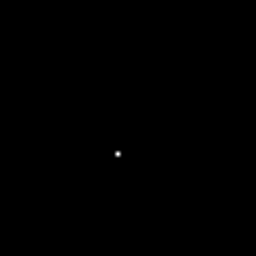

In [71]:
plot_image(y_pred[4])

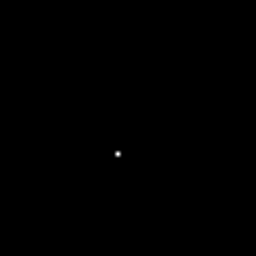

In [72]:
tf.keras.utils.array_to_img(tf.image.resize(y_pred[4].astype('float32'), (256, 256)))

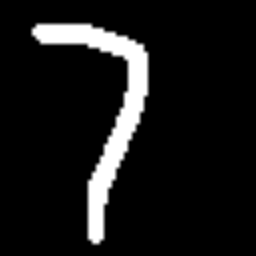

In [26]:
plot_image(labels_test[4])

# -------------------------------------------------------------------------------

In [ ]:
input_shape = (64, 64, 3)

x = np.reshape(data_test[4], (-1, 64, 64, 3))
print(x.shape)
net = tf.keras.layers.Conv2D(64, 2, input_shape=x[1:], activation = tf.nn.relu)
print("After conv2d: ", net.shape)
net = tf.keras.layers.MaxPooling2D(net, 2, 2, padding = 'same')

print(net.shape)

In [ ]:
input_shape = (64, 64, 3)
x = data_test[4]
y = tf.keras.layers.Conv1D(
                3, 1, activation='relu', input_shape=input_shape[1:])(x)

print((y).shape)
tf.keras.utils.array_to_img(tf.image.resize(y-1, (256, 256)))

In [ ]:
batch_size = 32

X_train = np.array(X[800:])
X_test = np.array(X[:800])
y_train = np.array(y[800:])
y_test = np.array(y[:800])

train_gen = OxfordPets(
    batch_size, img_size, X_train, y_train
)
train_gen

# Testing

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
img_size = (64,64)
num_classes = 3 

tf.keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [ ]:
input_shape = (64,64,1)

def gen_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Flatten(activation='relu')
    tf.keras.layers.Dense(4096,activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(64*64, activation='relu'),
    tf.keras.layers.Reshape((64, 64))
        
     ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model



In [ ]:
model = gen_model()

In [ ]:
EPOCHS = 10
model.fit(X_train, y_train, epochs=EPOCHS, steps_per_epoch=5)

In [ ]:
model.summary()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("Predicted Path Image")
plot_image(y_pred[4])

In [ ]:
print("Real Path Image")
plot_image(y_test[5])

# ---------------------------------------------------